In [1]:
import pandas as pd
import string
import nltk
import re
import matplotlib.pyplot as plt

In [3]:
reviews = pd.read_json('../data/restaurant_reviews_1900k.json', lines=True)

In [4]:
reviews.head()

,business_id,cool,date,funny,review_id,stars,text,useful,user_id
0,ikCg8xy5JIg_NGPx-MSIDA,0,2018-01-09 20:56:38,0,yi0R0Ugj_xUx_Nek0-_Qig,5,Went in for a lunch. Steak sandwich was delici...,0,dacAIZ6fTM6mqwW5uxkskg
1,eU_713ec6fTGNO4BegRaww,0,2013-01-20 13:25:59,0,fdiNeiN_hoCxCMy2wTRW9g,4,I'll be the first to admit that I was not exci...,0,w31MKYsNFMrjhWxxAb5wIw
2,3fw2X5bZYeW9xCz_zGhOHg,5,2016-05-07 01:21:02,4,G7XHMxG0bx9oBJNECG4IFg,3,Tracy dessert had a big name in Hong Kong and ...,5,jlu4CztcSxrKx56ba1a5AQ
3,zvO-PJCpNk4fgAVUnExYAA,1,2010-10-05 19:12:35,1,8e9HxxLjjqc9ez5ezzN7iQ,1,This place has gone down hill. Clearly they h...,3,d6xvYpyzcfbF_AZ8vMB7QA
4,8mIrX_LrOnAqWsB5JrOojQ,0,2011-11-30 02:11:15,0,kbtscdyz6lvrtGjD1quQTg,4,"Like walking back in time, every Saturday morn...",0,FIk4lQQu1eTe2EpzQ4xhBA


In [5]:
reviews['clean_text'] = reviews['text']

### Removing unnecessary characters

In [6]:
# Remove unnecessary characters here
reviews['clean_text'] = reviews['clean_text'].apply(lambda x: [x.replace("*", "").\
                                                   replace("#", "").\
                                                   replace("-", "")][0])

### Remove punctuation

In [7]:
# Remove all punctuation
reviews['clean_text'] = reviews['clean_text'].apply(lambda x: x.translate(str.maketrans("", "", string.punctuation)))

### Lemmatization and stemming

In [8]:
# Lemmatization and stemming
from nltk.stem import PorterStemmer

ps = PorterStemmer()
reviews['clean_text'] = reviews['clean_text'].apply(lambda x: [ps.stem(x)][0])

### Fix contractions - DON'T RUN YET

In [28]:
from contractions import contractions_dict
nltk.download('punkt')
# Code retrieved from this page: https://medium.com/@pemagrg/pre-processing-text-in-python-ad13ea544dae
def expand_contractions(text, contractions_dict):
    contractions_pattern = re.compile('({})'.format('|'.join(contractions_dict.keys())),
                                      flags=re.IGNORECASE | re.DOTALL)
    
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contractions_dict.get(match) \
            if contractions_dict.get(match) \
            else contractions_dict.get(match.lower())
        expanded_contraction = expanded_contraction
        return expanded_contraction
    
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text
    
reviews['clean_text'] = reviews['clean_text'].\
                                        apply(lambda x: [expand_contractions(x,contractions_dict)][0])


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Fernando\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Removing stop words

In [9]:
# Download set of stop words
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words_set = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/fernando/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
reviews['clean_text'] = reviews['clean_text'].str.lower().str.split()

In [11]:
# Removing stop words
reviews['clean_text'] = reviews['clean_text'].apply(lambda x: [item for item in x if item not in stop_words_set])

### Fix Mispellings - DON'T RUN YET

In [ ]:
from spellchecker import SpellChecker

spell = SpellChecker()

# find those words that may be misspelled
misspelled_wordcount = 0

def fix_misspellings(review):
    global misspelled_wordcount
    global spell
    
    misspelled = spell.unknown(review)
    
    for i in range(len(review)):
        if review[i] in misspelled:
            review[i] = spell.correction(review[i])
    
    misspelled_wordcount += len(misspelled)
    return review

reviews['clean_text'] = reviews['clean_text'].apply(lambda x: fix_misspellings(x))

### Tokenizing

In [12]:
# Convert back to string, takes a while to run
reviews['clean_text'] = reviews['clean_text'].apply(lambda x: [' '.join(x)][0])

In [13]:
from nltk.tokenize import word_tokenize
nltk.download('punkt')
reviews['tokenized_text'] = reviews['clean_text'].apply(lambda x: word_tokenize(x))

## EDA

In [17]:
ratings_count = reviews.groupby('stars')['review_id'].nunique()

In [18]:
ratings_count

stars
1    221530
2    174982
3    250994
4    494042
5    746368
Name: review_id, dtype: int64

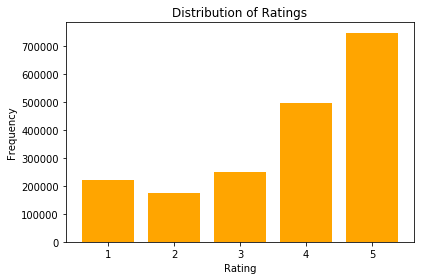

In [20]:
plt.bar([1, 2, 3, 4, 5], [count for count in ratings_count], color='orange')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Ratings')
plt.tight_layout()
plt.savefig('figures/ratings.png')

#### Most Common Words

In [21]:
from collections import Counter
word_frequency = Counter(" ".join(reviews["clean_text"]).split())

In [22]:
word_frequency.most_common(15)

[('food', 1430484),
 ('good', 1164320),
 ('place', 1032528),
 ('great', 864626),
 ('service', 730171),
 ('like', 687357),
 ('one', 594235),
 ('time', 570025),
 ('back', 555877),
 ('get', 553488),
 ('really', 513671),
 ('would', 511924),
 ('go', 495654),
 ('ordered', 440597),
 ('also', 419975)]

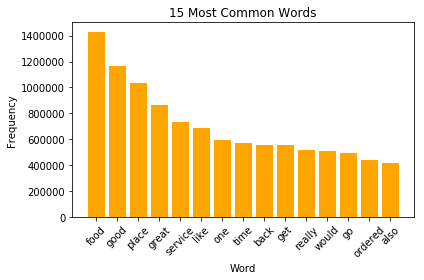

In [23]:
most_common = word_frequency.most_common(15)
plt.bar([i[0] for i in most_common], [i[1] for i in most_common], color='orange')
plt.xticks(rotation=45)
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.title('15 Most Common Words')
plt.tight_layout()
plt.savefig('figures/15_common.png')

In [24]:
most_common_5 = Counter(" ".join(reviews[reviews.stars == 5]['clean_text']).split()).most_common(15)

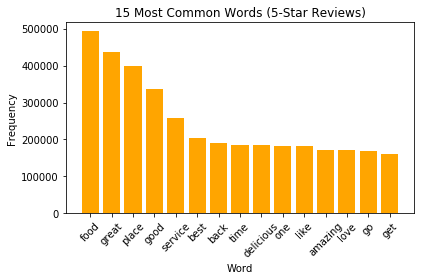

In [25]:
plt.bar([i[0] for i in most_common_5], [i[1] for i in most_common_5], color='orange')
plt.xticks(rotation=45)
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.title('15 Most Common Words (5-Star Reviews)')
plt.tight_layout()
plt.savefig('figures/15_common_5star.png')

In [26]:
most_common_1 = Counter(" ".join(reviews[reviews.stars == 1]['clean_text']).split()).most_common(15)

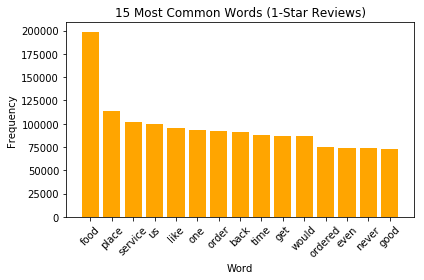

In [27]:
plt.bar([i[0] for i in most_common_1], [i[1] for i in most_common_1], color='orange')
plt.xticks(rotation=45)
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.title('15 Most Common Words (1-Star Reviews)')
plt.tight_layout()
plt.savefig('figures/15_common_1star.png')

#### Statistics on Review Length (after removing stop-words)

In [28]:
reviews['text_length'] = reviews['tokenized_text'].apply(lambda x: len(x))

In [29]:
reviews['text_length'].describe()

count    1.887916e+06
mean     5.607408e+01
std      5.168042e+01
min      0.000000e+00
25%      2.200000e+01
50%      4.000000e+01
75%      7.100000e+01
max      8.170000e+02
Name: text_length, dtype: float64

In [30]:
reviews['text_length'] = reviews['clean_text'].apply(lambda x: len(x.split(' ')))

In [31]:
reviews['text_length'].describe()

count    1.887916e+06
mean     5.604899e+01
std      5.165827e+01
min      1.000000e+00
25%      2.200000e+01
50%      4.000000e+01
75%      7.100000e+01
max      8.170000e+02
Name: text_length, dtype: float64

In [32]:
reviews['text_length_1'] = reviews['clean_text'][reviews.stars == 1].apply(lambda x: len(x.split(' ')))

In [33]:
reviews['text_length_1'].describe()

count    221530.000000
mean         62.844504
std          56.460219
min           1.000000
25%          26.000000
50%          46.000000
75%          80.000000
max         571.000000
Name: text_length_1, dtype: float64

In [34]:
reviews['text_length_5'] = reviews['clean_text'][reviews.stars == 5].apply(lambda x: len(x.split(' ')))

In [35]:
reviews['text_length_5'].describe()

count    746368.000000
mean         45.194911
std          43.937884
min           1.000000
25%          19.000000
50%          31.000000
75%          55.000000
max         648.000000
Name: text_length_5, dtype: float64

In [36]:
mean_words = {}
for i in range(1,6):
    mean_words[i] = reviews['clean_text'][reviews.stars == i].apply(lambda x: len(x.split(' '))).describe()['mean']

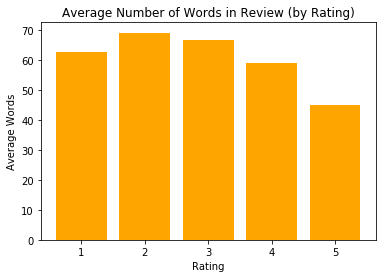

In [37]:
plt.bar(list(mean_words.keys()), list(mean_words.values()), color='orange')
plt.xticks()
plt.xlabel('Rating')
plt.ylabel('Average Words')
plt.title('Average Number of Words in Review (by Rating)')
plt.savefig('figures/mean_wordcount.png')

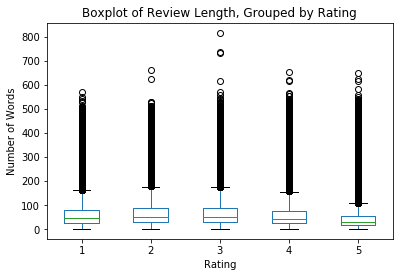

In [38]:
reviews.boxplot(column='text_length', by='stars', grid=False)
plt.title('Boxplot of Review Length, Grouped by Rating')
plt.xlabel('Rating')
plt.ylabel('Number of Words')
plt.suptitle("")
plt.savefig('figures/boxplot_words.png')